In [1]:
!nvidia-smi

Tue Dec 10 04:56:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     Off | 00000000:17:00.0 Off |                    0 |
| N/A   26C    P0              30W / 165W |      9MiB / 24576MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -Uqqq pip --progress-bar off
# !pip install -qqq torch==2.2.0 --progress-bar off
# !pip install -qqq transformers==4.37.2 --progress-bar off
# !pip install -qqq datasets==2.16.1 --progress-bar off
!pip install -qqq accelerate==1.2.0 --progress-bar off
!pip install -qqq bitsandbytes==0.45.0 --progress-bar off
!pip install -qqq peft==0.14.0 --progress-bar off
!pip install -qqq trl==0.12.2 --progress-bar off
!pip install -qqq flash-attn==2.7.2.post1 --progress-bar off
# !pip install -qqq --upgrade transformers --progress-bar off


## Data

In [3]:
import inspect
import random
import sqlite3

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
# from trl import DataCollatorForCompletionOnlyLM, SFTTrainer

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)
SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)

/home/dcn/anaconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!pip install gdown
!gdown 1rlX7CjTBeFLz2lvjaM1RbFGOX9beALQz

Downloading...
From: https://drive.google.com/uc?id=1rlX7CjTBeFLz2lvjaM1RbFGOX9beALQz
To: /home/dcn/tiny-llm/crypto-news-db.zip
100%|██████████████████████████████████████| 4.85M/4.85M [00:01<00:00, 3.88MB/s]


In [5]:
!unzip crypto-news-db.zip


Archive:  crypto-news-db.zip
  inflating: crypto-news.db          


In [6]:
connection = sqlite3.connect("crypto-news.db")
train_df = pd.read_sql_query("SELECT * FROM train", connection)
val_df = pd.read_sql_query("SELECT * FROM validation", connection)
test_df = pd.read_sql_query("SELECT * FROM test", connection)

train_df.shape, val_df.shape, test_df.shape

((24829, 9), (4966, 9), (1242, 9))

In [7]:
train_df.head()

,date,source,subject,text,title,url,sentiment,polarity,subjectivity
0,2022-04-12 12:02:00,CryptoPotato,ethereum,IDEG's new investment vehicle is part of its t...,IDEG Appoints Coinbase Prime as Strategic Part...,https://cryptopotato.com/ideg-appoints-coinbas...,positive,0.05,0.18
1,2022-10-26 18:00:00,CryptoNews,altcoin,"IBAT, the project's token of Battle infinity, ...",Battle Infinity Token Trending on CoinGecko - ...,https://cryptonews.com/news/battle-infinity-to...,positive,0.55,0.70
2,2023-02-08 16:00:00,CryptoNews,altcoin,"Get your daily, bite-sized digest of cryptoass...",Today in Crypto: Brave Reveals Solana Dapp Sup...,https://cryptonews.com/news/today-crypto-brave...,neutral,0.00,0.00
3,2022-03-05 19:20:00,CryptoPotato,blockchain,A BlockFi study found out that US women have s...,33% of Surveyed American Women Intend to Buy C...,https://cryptopotato.com/33-of-surveyed-americ...,neutral,0.00,0.00
4,2022-04-20 19:16:24,CoinTelegraph,blockchain,The symbol was quickly 'erased' via a communit...,Shiba Inu blacklists user for drawing hate sym...,https://cointelegraph.com/news/shiba-inu-black...,positive,0.33,0.50


In [8]:
def create_grid(n_rows, n_columns):
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_columns, figsize=(n_columns * 5, n_rows * 4)
    )
    return fig, axes.flatten()

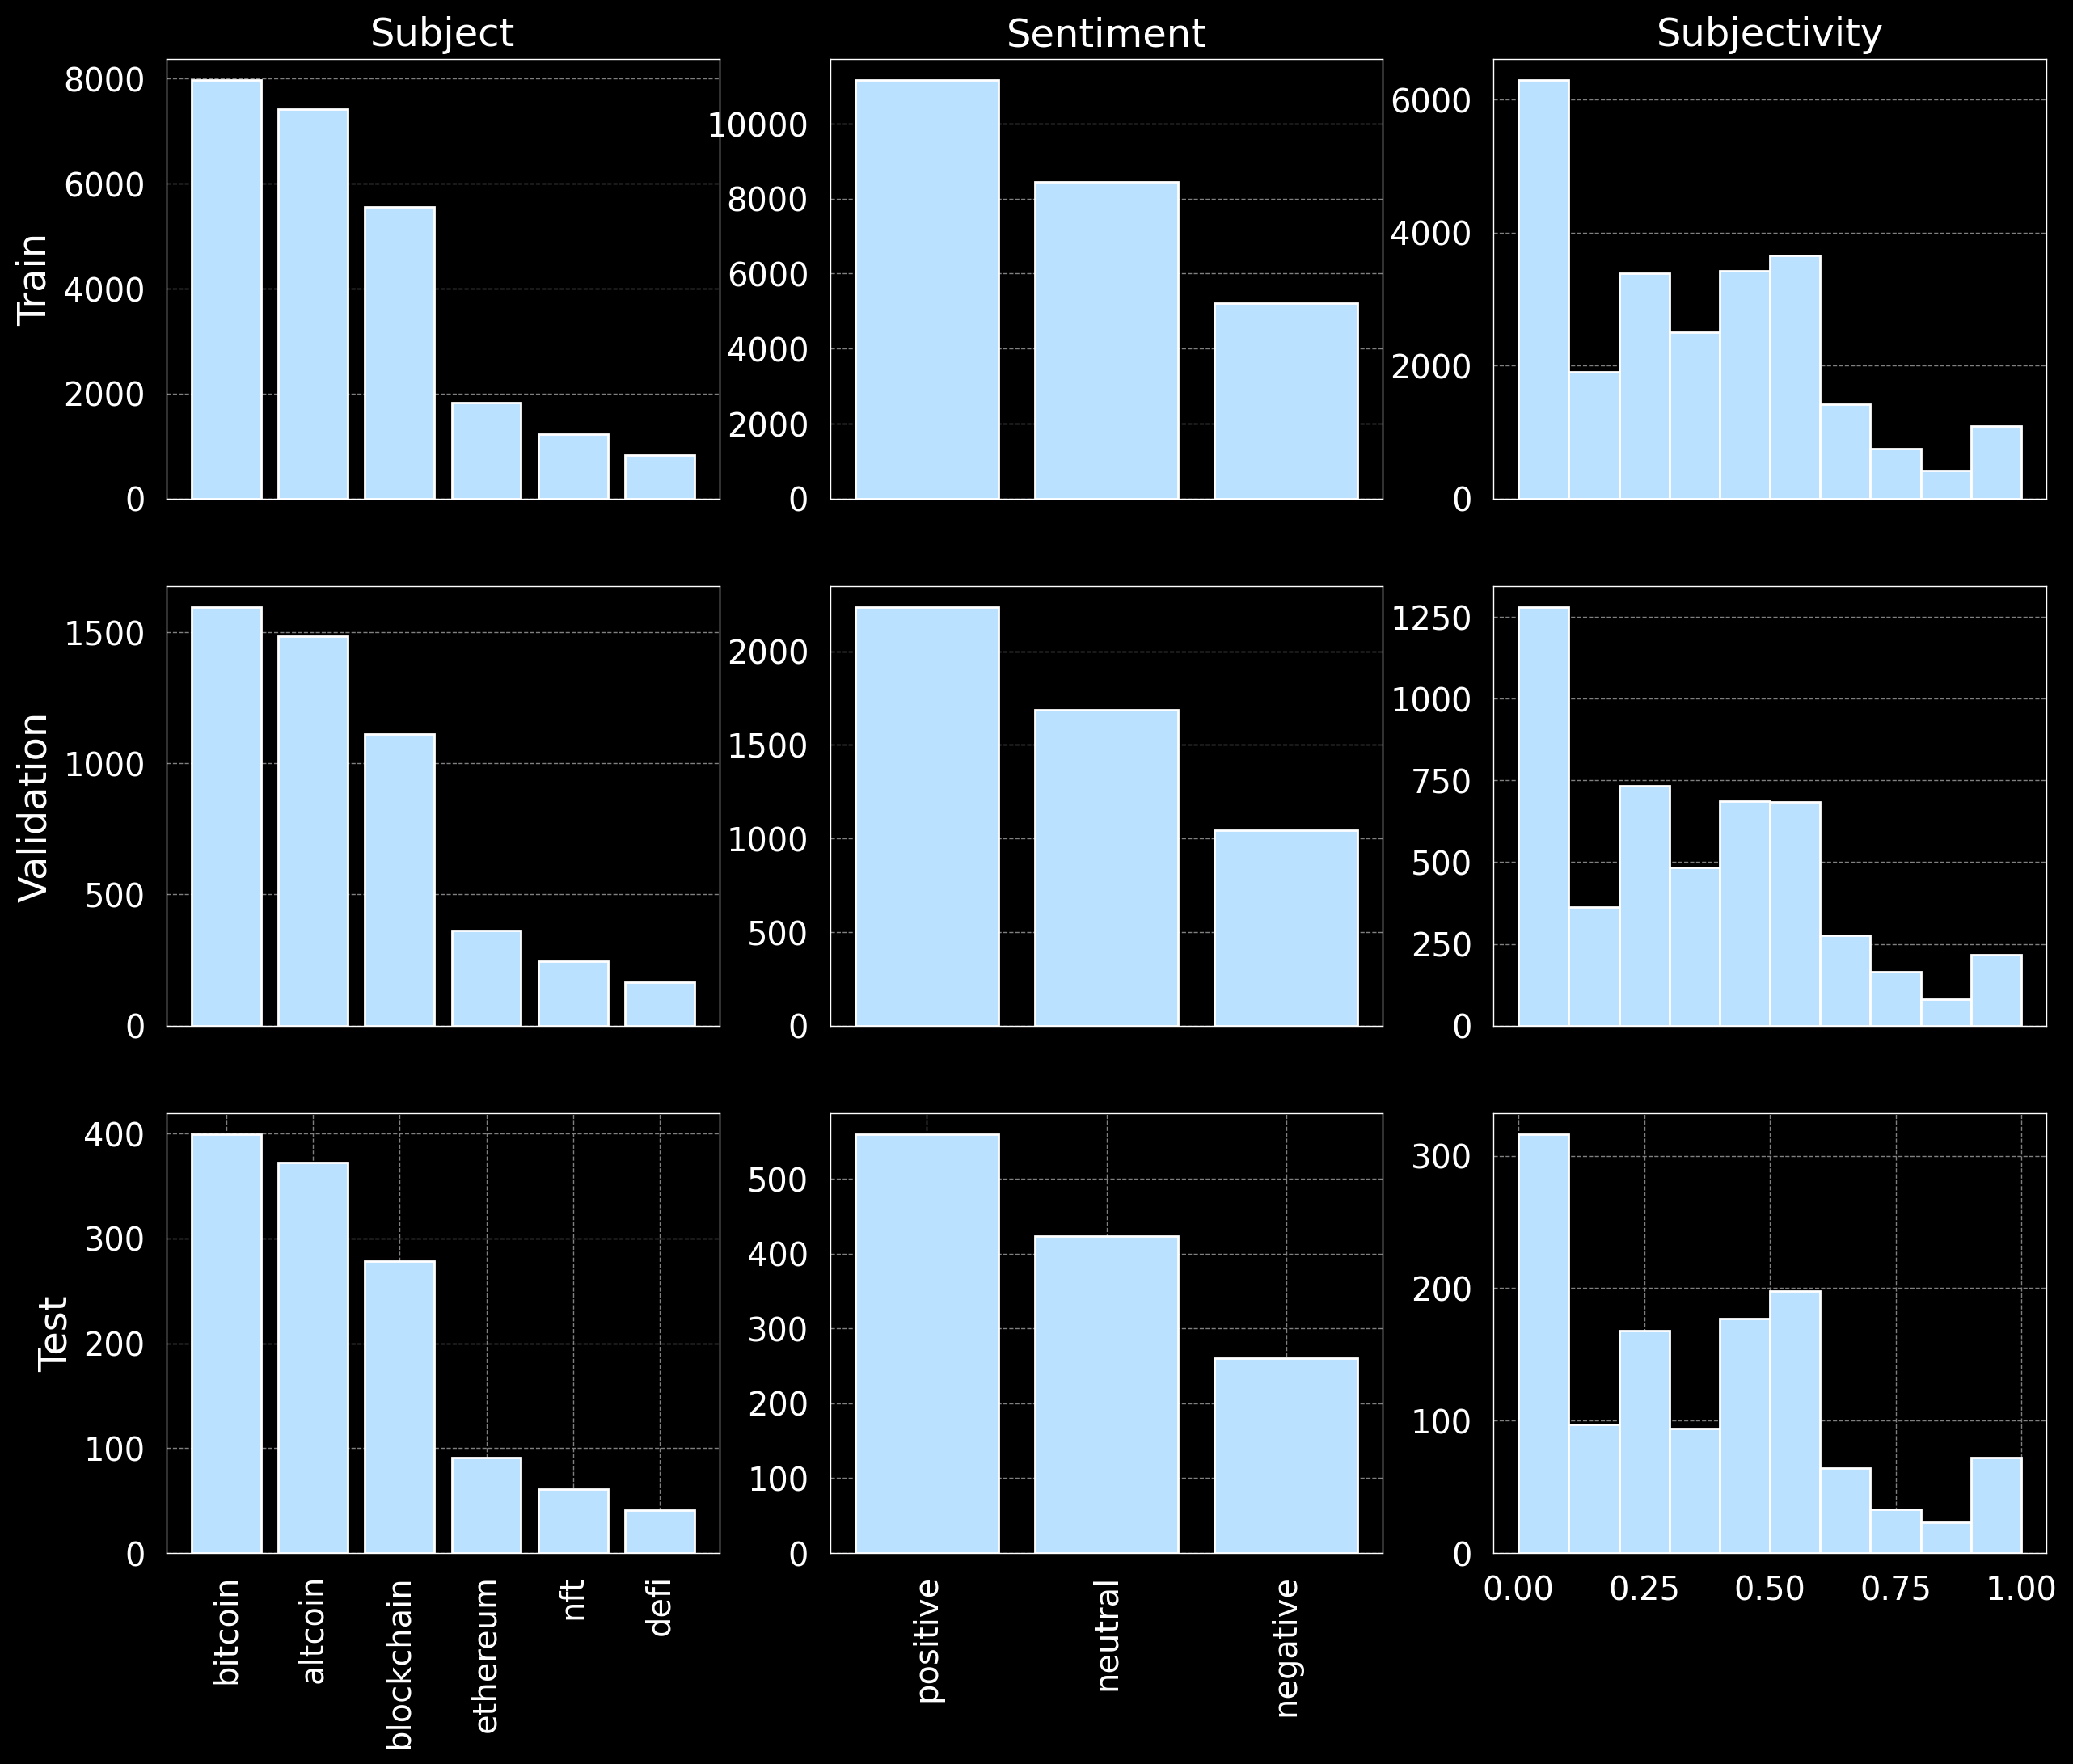

In [9]:
fig, axes = create_grid(n_rows=3, n_columns=3)

subjects = [
    train_df.subject.value_counts(),
    val_df.subject.value_counts(),
    test_df.subject.value_counts(),
]
sentiments = [
    train_df.sentiment.value_counts(),
    val_df.sentiment.value_counts(),
    test_df.sentiment.value_counts(),
]
subjectivities = [train_df.subjectivity, val_df.subjectivity, test_df.subjectivity]

axes[0].bar(subjects[0].index, subjects[0].values)
axes[0].set_title("Subject")
axes[0].set_ylabel("Train")
axes[0].set_xticklabels([])
axes[0].set_xticks([])

axes[3].bar(subjects[1].index, subjects[1].values)
axes[3].set_ylabel("Validation")
axes[3].set_xticklabels([])
axes[3].set_xticks([])

axes[6].bar(subjects[2].index, subjects[2].values)
axes[6].set_ylabel("Test")
axes[6].set_xticks(axes[6].get_xticks())
axes[6].set_xticklabels(subjects[2].index, rotation=90)

axes[1].bar(sentiments[0].index, sentiments[0].values)
axes[1].set_title("Sentiment")
axes[1].set_xticklabels([])
axes[1].set_xticks([])

axes[4].bar(sentiments[1].index, sentiments[1].values)
axes[4].set_xticklabels([])
axes[4].set_xticks([])

axes[7].bar(sentiments[2].index, sentiments[2].values)
axes[7].set_xticks(axes[7].get_xticks())
axes[7].set_xticklabels(sentiments[2].index, rotation=90)

axes[2].hist(subjectivities[0])
axes[2].set_title("Subjectivity")
axes[2].set_xticklabels([])
axes[2].set_xticks([])

axes[5].hist(subjectivities[1])
axes[5].set_xticklabels([])
axes[5].set_xticks([])

axes[8].hist(subjectivities[2])

plt.show();

In [10]:
dataset = {
    "train": Dataset.from_pandas(train_df),
    "val": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
}
dataset

{'train': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 24829
 }),
 'val': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 4966
 }),
 'test': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 1242
 })}

In [15]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login
login(token = '')
MODEL_A_TINYLLAMA = "meta-llama/Llama-3.2-1B"
MODEL_B_Phi_3 = "microsoft/Phi-3-mini-128k-instruct"


## Initialize the models

### TinyLLAMA

In [16]:
dataset['train'][0]

{'date': '2022-04-12 12:02:00',
 'source': 'CryptoPotato',
 'subject': 'ethereum',
 'text': "IDEG's new investment vehicle is part of its thematic product suite - TIMES and it comes following a partnership with Coinbase.",
 'title': 'IDEG Appoints Coinbase Prime as Strategic Partner to Launch Ethereum Enhanced Portfolio',
 'url': 'https://cryptopotato.com/ideg-appoints-coinbase-prime-as-strategic-partner-to-launch-ethereum-enhanced-portfolio/',
 'sentiment': 'positive',
 'polarity': 0.05,
 'subjectivity': 0.18}

In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login
import inspect

# Login to HuggingFace Hub
login(token='')

# Define model and dataset
MODEL_A_TINYLLAMA = "meta-llama/Llama-3.2-1B"

# Example function for formatting input
def format_example(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
subject: {example["subject"]}
sentiment: {example["sentiment"]}
"""
    )

# Load the model and tokenizer
model_tiny_llama = AutoModelForCausalLM.from_pretrained(
    MODEL_A_TINYLLAMA,
    device_map="auto",
    trust_remote_code=True,
)
tokenizer_tiny_llama = AutoTokenizer.from_pretrained(MODEL_A_TINYLLAMA, padding=True, padding_side="left")


# Prepare inputs
formatted_input = format_example(dataset['train'][0])
model_inputs = tokenizer_tiny_llama(formatted_input, return_tensors="pt").to("cuda")  # Ensure inputs are on the correct device

# Generate predictions
generated_ids = model_tiny_llama.generate(**model_inputs, max_length=512)  # Adjust max_length as needed
decoded_output = tokenizer_tiny_llama.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(decoded_output)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


### Title:
IDEG Appoints Coinbase Prime as Strategic Partner to Launch Ethereum Enhanced Portfolio
### Text:
IDEG's new investment vehicle is part of its thematic product suite - TIMES and it comes following a partnership with Coinbase.
### Prediction:
subject: ethereum
sentiment: positive
date: 2022-09-28 00:00:00



In [14]:

PAD_TOKEN = "<pad>"


model_tiny_llama = AutoModelForCausalLM.from_pretrained(
    MODEL_A_TINYLLAMA,
    device_map="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2" if available
)
generated_ids = model.generate(tokenizer_tiny_llama)
padding_idx = tokenizer_tiny_llama.pad_token_id

model_tiny_llama.resize_token_embeddings(len(tokenizer_tiny_llama))
# Get the embedding layer and set padding_idx
# embedding_layer = model_tiny_llama.get_input_embeddings()
# embedding_layer.padding_idx = padding_idx


NameError: name 'model' is not defined

In [ ]:
tokenizer_tiny_llama
#In the context of Hugging Face's tokenizers, the bos_token and bos_token_id refer to the Beginning of Sequence (BOS) token and its corresponding ID in the tokenizer's vocabulary.
# tokenizer_tiny_llama.bos_token, tokenizer_tiny_llama.bos_token_id

In [ ]:
tokenizer_tiny_llama.eos_token, tokenizer_tiny_llama.eos_token_id

In [ ]:
# tokenizer_tiny_llama.pad_token, tokenizer_tiny_llama.pad_token_id

In [ ]:
#Check if PAD_TOKEN Exists: If PAD_TOKEN (like "<pad>") has been added to the tokenizer using tokenizer.add_special_tokens, it should appear in the vocabulary.
PAD_TOKEN in tokenizer_tiny_llama.get_vocab()

### Phi 3

In [18]:
PAD_TOKEN = "<pad>"
tokenizer_phi3 = AutoTokenizer.from_pretrained(MODEL_B_Phi_3, add_eos_token=True, use_fast=True)
tokenizer_phi3.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer_phi3.padding_side = "right"

model_phi3 = AutoModelForCausalLM.from_pretrained(
    MODEL_B_Phi_3,
    device_map="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2" if available
)
model_phi3.resize_token_embeddings(len(tokenizer_phi3), pad_to_multiple_of=8)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.18s/it]


Embedding(32016, 3072, padding_idx=32000)

## Token Counts

In [19]:
#template used

def format_example(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
subject: {example["subject"]}
sentiment: {example["sentiment"]}
"""
    )

In [20]:
print(format_example(dataset["train"][0]))

### Title:
IDEG Appoints Coinbase Prime as Strategic Partner to Launch Ethereum Enhanced Portfolio
### Text:
IDEG's new investment vehicle is part of its thematic product suite - TIMES and it comes following a partnership with Coinbase.
### Prediction:
subject: ethereum
sentiment: positive


### TinyLLama token counts

In [ ]:
#count the number of tokens in each example, finding the number of tokens we are going to need.
#we have a limit of 2048, so the number of tokens we are going to need is 200.
from tqdm import tqdm

token_counts_tiny_llama = []
# Compute token counts for tiny_llama tokenizer
for example in tqdm(dataset["train"], desc="Processing Tiny LLama"):
    token_counts_tiny_llama.append(
        len(
            tokenizer_tiny_llama(
                format_example(example),
                add_special_tokens=True,
                return_attention_mask=False,
            )["input_ids"]
        )
    )

token_counts_phi3 = []
# Compute token counts for phi3 tokenizer
for example in tqdm(dataset["train"], desc="Processing Phi3"):
    token_counts_phi3.append(
        len(
            tokenizer_phi3(
                format_example(example),
                add_special_tokens=True,
                return_attention_mask=False,
            )["input_ids"]
        )
    )

# Plot histograms for both tokenizers
plt.hist(token_counts_tiny_llama, bins=30, alpha=0.7, label="LLama3")
plt.hist(token_counts_phi3, bins=30, alpha=0.7, label="Phi3")

plt.axvline(200, color="red", linestyle="--", label="Token Limit (200)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Token Distribution")
plt.legend()
plt.show()

# Training

### TinyLLama

In [24]:
model_tiny_llama.pad_token_id = tokenizer_tiny_llama.pad_token_id
model_tiny_llama.config.pad_token_id = tokenizer_tiny_llama.pad_token_id

In [25]:
model_tiny_llama.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.45.2",
  "use_cache": true,
  "vocab_size": 128256
}

In [26]:
# check the model to see where we need to apply the LoRa scaling or the LoRa target modules
# self attention and mlp layers
model_tiny_llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

## Phi 3

In [21]:
model_phi3.pad_token_id = tokenizer_phi3.pad_token_id
model_phi3.config.pad_token_id = tokenizer_phi3.pad_token_id

In [22]:

model_phi3.config

Phi3Config {
  "_name_or_path": "microsoft/Phi-3-mini-128k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/Phi-3-mini-128k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/Phi-3-mini-128k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "model_type": "phi3",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32011,
  "resid_pdrop": 0.0,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "long_factor": [
      1.0700000524520874,
      1.1200000047683716,
      1.149999976158142,
      1.4199999570846558,
      1.5699999332427979,
      1.79999995231

In [23]:
model_phi3

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32016, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out

### LoRA Setup

#### RECALL

Fine-tuning with PEFT (Parameter-Efficient Fine-Tuning) is a method to adapt large language models (LLMs) for specific tasks without training the entire model. It works by freezing the LLM's weights and adding a few trainable parameters (like adapters) to learn the task-specific information

#### TinyLLAMA Lora Config

In [27]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config_tiny_llama = LoraConfig(
    r=128, # LoRa ranking of the metrics
    lora_alpha=128, # for scaling the parameters of LoRa
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model_tiny_llama = get_peft_model(model_tiny_llama, lora_config_tiny_llama) # get the peft_model on top of original model and adding the LoRa config

model_tiny_llama.print_trainable_parameters()

trainable params: 90,177,536 || all params: 1,325,991,936 || trainable%: 6.8008


#### Phi3 Lora Config

In [28]:
lora_config_phi3 = LoraConfig(
    r=128, # LoRa ranking of the metrics
    lora_alpha=128, # for scaling the parameters of LoRa
    target_modules=[
        "self_attn.o_proj",
        "self_attn.qkv_proj",
        
        "mlp.gate_up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model_phi3 = get_peft_model(model_phi3, lora_config_phi3) # get the peft_model on top of original model and adding the LoRa config

model_phi3.print_trainable_parameters()

trainable params: 201,326,592 || all params: 4,022,111,232 || trainable%: 5.0055


# Training on Completions

In [29]:
from trl import DataCollatorForCompletionOnlyLM, SFTTrainer

### TinyLLama

In [ ]:
response_template = "\n### Prediction:"
response_template_ids_tiny_llama = tokenizer_tiny_llama.encode(response_template, add_special_tokens=False)[
    2:
]
tokenizer_tiny_llama.add_special_tokens({'pad_token': '[PAD]'})
tokenizer_tiny_llama.padding_side='left'
collator_tiny_llama = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer_tiny_llama)

examples = [format_example(dataset["train"][0])]
encodings_tiny_llama = [tokenizer_tiny_llama(e) for e in examples]

# encodings_tiny_llama = [tokenizer_tiny_llama(e, padding=True, truncation=True) for e in examples]

dataloader_tiny_llama = DataLoader(encodings_tiny_llama, collate_fn=collator_tiny_llama, batch_size=8)


In [ ]:
batch_tiny_llama = next(iter(dataloader_tiny_llama))
batch_tiny_llama.keys()

In [ ]:

print(batch_tiny_llama["input_ids"])
print(batch_tiny_llama["attention_mask"])

In [ ]:
batch_tiny_llama["labels"]

### Phi3

In [ ]:
response_template_ids_phi3 = tokenizer_phi3.encode(response_template, add_special_tokens=False)[
    2:
]
collator_phi3 = DataCollatorForCompletionOnlyLM(response_template_ids_phi3, tokenizer=tokenizer_phi3)

encodings_phi3 = [tokenizer_phi3(e) for e in examples]

dataloader_phi3 = DataLoader(encodings_phi3, collate_fn=collator_phi3, batch_size=1)

In [ ]:
batch_phi3 = next(iter(dataloader_phi3))
batch_phi3.keys()

In [ ]:
batch_phi3["labels"]

# Training Arguments

### TinyLlama

In [ ]:
!pip install -Uqqq tensorboard  --progress-bar off


In [ ]:
from transformers import TrainingArguments

training_arguments_tiny_llama = TrainingArguments(
    output_dir="experiments",
    num_train_epochs=1,
    per_device_train_batch_size=8, # pass four examples to the GPU
    gradient_accumulation_steps=8, # accumulate on top of the batch
    optim="adamw_torch",
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True, quantization is not used to keep the model smaller and faster
    save_strategy="epoch",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    seed=SEED,
)

In [ ]:
def format_prompts(example):
    output_texts = []
    for i in range(len(example["title"])):
        text = inspect.cleandoc(
            f"""
### Title:
{example["title"][i]}
### Text:
{example["text"][i]}
### Prediction:
subject: {example["subject"][i]}
sentiment: {example["sentiment"][i]}
"""
        )
        output_texts.append(text)
    return output_texts

In [ ]:
dataset

In [ ]:
from trl import SFTTrainer
tokenizer_tiny_llama.padding_side='right'
trainer_tiny_llama = SFTTrainer(
    model=model_tiny_llama,
    args=training_arguments_tiny_llama,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=tokenizer_tiny_llama,  # Correct usage of tokenizer
    packing=False,  # Disable sequence packing
    formatting_func=format_prompts,
    data_collator=collator_tiny_llama,
    # max_seq_length=1024,

    
)

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir experiments/runs
# %tensorboard --logdir logs/fit

# !kill 40572

In [ ]:
trainer_tiny_llama.train()

In [ ]:
trainer_tiny_llama.model.save_pretrained("tiny-llama-crypto-sentiment-model")
tokenizer_tiny_llama.save_pretrained("tiny-llama-crypto-sentiment-model")

### Phi3

In [ ]:
training_arguments_phi3 = TrainingArguments(
    output_dir="experiments",
    num_train_epochs=1,
    per_device_train_batch_size=4, # pass four examples to the GPU
    gradient_accumulation_steps=4, # accumulate on top of the batch
    optim="adamw_torch",
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True, quantization is not used to keep the model smaller and faster
    save_strategy="epoch",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    seed=SEED,
)

In [ ]:
trainer_phi3 = SFTTrainer(
    model=model_phi3,
    args=training_arguments_phi3,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=tokenizer_phi3,
    max_seq_length=1024,
    formatting_func=format_prompts,
    data_collator=collator_phi3,
)

In [ ]:
trainer_phi3.train()

In [ ]:
trainer_phi3.model.save_pretrained("phi3-crypto-sentiment-model")
tokenizer_phi3.save_pretrained("phi3-crypto-sentiment-model")

### Roberta

In [ ]:
lora_config_roberta = LoraConfig(
    r=6, # LoRa ranking of the metrics
    lora_alpha=8, # for scaling the parameters of LoRa
    target_modules=[
         "attention.self.query",
            "attention.self.value",
            "attention.output.dense",
            "intermediate.dense",
            "output.dense",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model_roberta_base = get_peft_model(model_roberta_base, lora_config_roberta) # get the peft_model on top of original model and adding the LoRa config

model_roberta_base.print_trainable_parameters()

In [ ]:
training_arguments_roberta_base = TrainingArguments(
    output_dir="experiments",
    num_train_epochs=1,
    per_device_train_batch_size=8, # pass four examples to the GPU
    gradient_accumulation_steps=8, # accumulate on top of the batch
    optim="adamw_torch",
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True, quantization is not used to keep the model smaller and faster
    save_strategy="epoch",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    seed=SEED,
)

In [ ]:
trainer_roberta_base = SFTTrainer(
    model=model_roberta_base,
    args=training_arguments_roberta_base,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=tokenizer_roberta_base,
    max_seq_length=256,
    formatting_func=format_prompts,
    data_collator=collator_roberta_base,
)

In [ ]:
trainer_roberta_base.train()

In [ ]:
trainer_roberta_base.model.save_pretrained("roberta-base-crypto-sentiment-model")
tokenizer_roberta_base.save_pretrained("roberta-base-crypto-sentiment-model")

# Load Trained Model TinyLLAMA

In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME_TINY_LLAMA = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

base_model_tiny_llama = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME_TINY_LLAMA,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)

base_model_tiny_llama.resize_token_embeddings(len(tokenizer_tiny_llama), pad_to_multiple_of=8)

model_new_tiny_llama = PeftModel.from_pretrained(base_model_tiny_llama, "tiny-llama-crypto-sentiment-model")
model_new_tiny_llama = model_new_tiny_llama.merge_and_unload()

tokenizer_tiny_llama = AutoTokenizer.from_pretrained(
    "tiny-llama-crypto-sentiment-model", trust_remote_code=True
)

tokenizer_tiny_llama.pad_token, tokenizer_tiny_llama.pad_token_id, tokenizer_tiny_llama.padding_side

In [ ]:
model_new_tiny_llama.pad_token_id = tokenizer_tiny_llama.pad_token_id
model_new_tiny_llama.config.pad_token_id = tokenizer_tiny_llama.pad_token_id

## Evaluation

In [ ]:
from transformers import pipeline

pipe_tiny_llama = pipeline(
    task="text-generation",
    model=model_new_tiny_llama,
    tokenizer=tokenizer_tiny_llama,
    max_new_tokens=16,
    return_full_text=False,
)

In [ ]:
def format_for_prediction(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
"""
    )

In [ ]:
from transformers import logging

logging.set_verbosity(logging.CRITICAL)

In [ ]:
for i in range(10):
    example = dataset["test"][i]
    print(f"Example {i + 1}\n")
    text = inspect.cleandoc(
        f"""
        Title: {example["title"]}
        Text: {example["text"]}
        Subject: {example["subject"]}
        Sentiment: {example["sentiment"]}
    """
    )
    print(text)
    print("\nPrediction:")
    outputs_tiny_llama = pipe_tiny_llama(format_for_prediction(example))
    print(outputs_tiny_llama[0]["generated_text"])
    print()

In [ ]:
import re

from tqdm import tqdm

rows = []

for i in tqdm(range(len(dataset["test"]))):
    example = dataset["test"][i]
    outputs_tiny_llama = pipe_tiny_llama(format_for_prediction(example))
    text = outputs_tiny_llama[0]["generated_text"]
    parts = re.split(r"[:\n]", text.strip())
    subject, sentiment = parts[1].strip(), parts[3].strip()

    rows.append(
        {
            "title": example["title"],
            "text": example["text"],
            "true_subject": example["subject"],
            "true_sentiment": example["sentiment"],
            "pred_subject": subject,
            "pred_sentiment": sentiment,
        }
    )

In [ ]:
predictions_df = pd.DataFrame(rows)
predictions_df.head()

In [ ]:
(predictions_df["true_subject"] == predictions_df["pred_subject"]).sum() / len(
    predictions_df
)

In [ ]:
labels = predictions_df["true_subject"].unique().tolist()
cf_matrix = confusion_matrix(
    predictions_df["true_subject"], predictions_df["pred_subject"], labels=labels
)
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    cmap=cmap,
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [ ]:
predictions_df[predictions_df["true_subject"] != predictions_df["pred_subject"]].head(
    n=10
)[["title", "text", "true_subject", "pred_subject"]]

In [ ]:
(predictions_df["true_sentiment"] == predictions_df["pred_sentiment"]).sum() / len(
    predictions_df
)

In [ ]:
labels = predictions_df["true_sentiment"].unique().tolist()
cf_matrix = confusion_matrix(
    predictions_df["true_sentiment"], predictions_df["pred_sentiment"], labels=labels
)
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    cmap=cmap,
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [ ]:
predictions_df[
    predictions_df["true_sentiment"] != predictions_df["pred_sentiment"]
].head(n=10)[["title", "text", "true_sentiment", "pred_sentiment"]]

# Load Trained Model Phi3

In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

# MODEL_B_Phi_3 = "microsoft/Phi-3-mini-4k-instruct"
# MODEL_C_ROBERTA = "FacebookAI/roberta-base"
# MODEL_D_distilbert = "distilbert/distilbert-base-uncased"

MODEL_NAME_phi3 = MODEL_B_Phi_3

base_model_phi3 = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME_phi3,
    # device_map="auto",
    # torch_dtype=torch.float16,
    trust_remote_code=True,
)

base_model_phi3.resize_token_embeddings(len(tokenizer_phi3), pad_to_multiple_of=8)

model_new_phi3 = PeftModel.from_pretrained(base_model_phi3, "phi3-crypto-sentiment-model")
model_new_phi3 = model_new_phi3.merge_and_unload()

tokenizer_phi3 = AutoTokenizer.from_pretrained(
    "phi3-crypto-sentiment-model", trust_remote_code=True
)

tokenizer_phi3.pad_token, tokenizer_phi3.pad_token_id, tokenizer_phi3.padding_side

## Evaluation

In [ ]:
pipe_phi3 = pipeline(
    task="text-generation",
    model=model_new_phi3,
    tokenizer=tokenizer_phi3,
    max_new_tokens=16,
    return_full_text=False,
)

In [ ]:
for i in range(5):
    example = dataset["test"][i]
    print(f"Example {i + 1}\n")
    text = inspect.cleandoc(
        f"""
        Title: {example["title"]}
        Text: {example["text"]}
        Subject: {example["subject"]}
        Sentiment: {example["sentiment"]}
    """
    )
    print(text)
    print("\nPrediction:")
    outputs_phi3 = pipe_phi3(format_for_prediction(example))
    print(outputs_phi3[0]["generated_text"])
    print()

In [ ]:
rows = []

for i in tqdm(range(len(dataset["test"]))):
    example = dataset["test"][i]
    outputs_phi3 = pipe_phi3(format_for_prediction(example))
    text = outputs_phi3[0]["generated_text"]
    parts = re.split(r"[:\n]", text.strip())
    subject, sentiment = parts[1].strip(), parts[3].strip()

    rows.append(
        {
            "title": example["title"],
            "text": example["text"],
            "true_subject": example["subject"],
            "true_sentiment": example["sentiment"],
            "pred_subject": subject,
            "pred_sentiment": sentiment,
        }
    )

In [ ]:
predictions_df = pd.DataFrame(rows)
predictions_df.head()

In [ ]:
(predictions_df["true_subject"] == predictions_df["pred_subject"]).sum() / len(
    predictions_df
)

In [ ]:
predictions_df[predictions_df["true_subject"] != predictions_df["pred_subject"]].head(
    n=10
)[["title", "text", "true_subject", "pred_subject"]]

In [ ]:
(predictions_df["true_sentiment"] == predictions_df["pred_sentiment"]).sum() / len(
    predictions_df
)

# Load Trained Model Roberta

In [ ]:

MODEL_NAME_ROBERTA_BASE = MODEL_C_ROBERTA

base_model_roberta_base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME_ROBERTA_BASE,
    # device_map="auto",
    # torch_dtype=torch.float16,
    trust_remote_code=True,
)

base_model_roberta_base.resize_token_embeddings(len(tokenizer_roberta_base), pad_to_multiple_of=8)

model_new_roberta_base = PeftModel.from_pretrained(base_model_roberta_base, "roberta_base-crypto-sentiment-model")
model_new_roberta_base = model_roberta_base.merge_and_unload()

tokenizer_phi3 = AutoTokenizer.from_pretrained(
    "phi3-crypto-sentiment-model", trust_remote_code=True
)

tokenizer_phi3.pad_token, tokenizer_phi3.pad_token_id, tokenizer_phi3.padding_side

### Evaluation

In [ ]:
pipe_roberta_base = pipeline(
    task="text-generation",
    model=base_model_roberta_base,
    tokenizer=tokenizer_roberta_base,
    max_new_tokens=16,
    return_full_text=False,
)

In [ ]:
for i in range(5):
    example = dataset["test"][i]
    print(f"Example {i + 1}\n")
    text = inspect.cleandoc(
        f"""
        Title: {example["title"]}
        Text: {example["text"]}
        Subject: {example["subject"]}
        Sentiment: {example["sentiment"]}
    """
    )
    print(text)
    print("\nPrediction:")
    outputs_roberta_base = pipe_roberta_base(format_for_prediction(example))
    print(outputs_roberta_base[0]["generated_text"])
    print()

In [ ]:
rows = []

for i in tqdm(range(len(dataset["test"]))):
    example = dataset["test"][i]
    outputs_roberta_base = pipe_roberta_base(format_for_prediction(example))
    text = outputs_roberta_base[0]["generated_text"]
    print(outputs_roberta_base)
    parts = re.split(r"[:\n]", text.strip())
    subject, sentiment = parts[1].strip(), parts[3].strip()

    rows.append(
        {
            "title": example["title"],
            "text": example["text"],
            "true_subject": example["subject"],
            "true_sentiment": example["sentiment"],
            "pred_subject": subject,
            "pred_sentiment": sentiment,
        }
    )